# How to simulate the LUCJ ansatz using matrix product states

Following from the previous guide, we now show how to use ffsim to simulate the [LUCJ ansatz](../explanations/lucj.ipynb) using matrix product states. In this way, we can calculate an approximation to the LUCJ energy, which is itself an approximation to the ground state energy, for an ethene molecule. This is particularly useful in complicated cases, such as for large molecules, where even the LUCJ energy cannot be computed exactly. 

As before, let's start by building the molecule.

In [1]:
import pyscf
import pyscf.mcscf

import ffsim

# Build an ethene molecule
bond_distance = 1.339
a = 0.5 * bond_distance
b = a + 0.5626
c = 0.9289
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ["C", (0, 0, a)],
        ["C", (0, 0, -a)],
        ["H", (0, c, b)],
        ["H", (0, -c, b)],
        ["H", (0, c, -b)],
        ["H", (0, -c, -b)],
    ],
    basis="sto-6g",
    symmetry="d2h",
)

# Define active space
active_space = range(mol.nelectron // 2 - 2, mol.nelectron // 2 + 2)

# Get molecular data and molecular Hamiltonian (one- and two-body tensors)
scf = pyscf.scf.RHF(mol).run()
mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
norb = mol_data.norb
nelec = mol_data.nelec
n_alpha, n_beta = nelec
mol_hamiltonian = mol_data.hamiltonian

# Compute FCI energy
mol_data.run_fci()

print(f"norb = {norb}")
print(f"nelec = {nelec}")

/home/bart/TeNPy/tenpy/tools/optimization.py:317: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


converged SCF energy = -77.8266321248745
Parsing /tmp/tmp8abr64eg
converged SCF energy = -77.8266321248745
CASCI E = -77.8742165643863  E(CI) = -4.02122442107772  S^2 = 0.0000000
norb = 4
nelec = (2, 2)


Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.scf.hf.RHF'>
/home/bart/PycharmProjects/ffsim/.ffsim_dev/lib/python3.12/site-packages/pyscf/gto/mole.py:1294: UserWarning: Function mol.dumps drops attribute energy_nuc because it is not JSON-serializable
  warnings.warn(msg)
/home/bart/PycharmProjects/ffsim/.ffsim_dev/lib/python3.12/site-packages/pyscf/gto/mole.py:1294: UserWarning: Function mol.dumps drops attribute intor_symmetric because it is not JSON-serializable
  warnings.warn(msg)


Since our molecule has a closed-shell Hartree-Fock state, we'll use the spin-balanced variant of the UCJ ansatz, [UCJOpSpinBalanced](../api/ffsim.rst#ffsim.UCJOpSpinBalanced). We'll initialize the ansatz from t2 amplitudes obtained from a CCSD calculation and we'll restrict same-spin interactions to a line topology, and opposite-spin interactions to those within the same spatial orbital, which allows the ansatz to be simulated directly on a square lattice.

The following code cell initializes the LUCJ ansatz operator.

In [2]:
from pyscf import cc

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = cc.CCSD(
    scf,
    frozen=[i for i in range(mol.nao_nr()) if i not in active_space],
).run()

# Construct LUCJ operator
n_reps = 1
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]
interaction_pairs = (pairs_aa, pairs_ab)

lucj_operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    ccsd.t2, n_reps=n_reps, interaction_pairs=interaction_pairs
)

E(CCSD) = -77.87421536374032  E_corr = -0.04758323886585947


<class 'pyscf.cc.ccsd.CCSD'> does not have attributes  converged


## Convert the Hamiltonian to a matrix product operator (MPO)

Currently, our Hamiltonian is an instance of the `MolecularHamiltonian` class. Using the `from_molecular_hamiltonian` method from the `MolecularHamiltonianMPOModel` class, we can convert this to a TeNPy `MPOModel`, which respects the fermionic symmetries. We can then construct the MPO using the `H_MPO` attribute and use this `MPO` object as outlined in the [TeNPy MPO documentation](https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mpo.MPO.html#tenpy.networks.mpo.MPO). For example, the `MPO` class attribute `chi` tells us the MPO bond dimension, which is an important indicator of how complicated the Hamiltonian is in an MPO representation.

In [3]:
from ffsim.tenpy.hamiltonians.molecular_hamiltonian import MolecularHamiltonianMPOModel

print("original Hamiltonian type = ", type(mol_hamiltonian))
hamiltonian_mpo_model = MolecularHamiltonianMPOModel.from_molecular_hamiltonian(
    mol_hamiltonian
)
hamiltonian_mpo = hamiltonian_mpo_model.H_MPO
print("converted Hamiltonian type = ", type(hamiltonian_mpo))
print("maximum MPO bond dimension = ", max(hamiltonian_mpo.chi))

original Hamiltonian type =  <class 'ffsim.hamiltonians.molecular_hamiltonian.MolecularHamiltonian'>
converted Hamiltonian type =  <class 'tenpy.networks.mpo.MPO'>
maximum MPO bond dimension =  54


## Construct the LUCJ circuit as a matrix product state (MPS)

Our wavefunction ansatz operator, on the other hand, is an instance of the `UCJOpSpinBalanced` class. In a future guide, we will show in detail how we can use such an ansatz to build and transpile Qiskit quantum circuits. In this guide, we will use this ansatz operator to construct our wavefunction as a TeNPy MPS, which respects the fermionic symmetries. Behind the scenes, this executes the ansatz as a fermionic circuit using the TEBD algorithm. 

We can pass the `options` dictionary and `norm_tol` to the `lucj_circuit_as_mps` function to control the accuracy of our MPS approximation. The `options` parameter is detailed in the [TeNPy TEBDEngine documentation](https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.tebd.TEBDEngine.html#tenpy.algorithms.tebd.TEBDEngine). The `norm_tol` parameter is defined in other contexts in the TeNPy library, e.g. in the [TeNPy DMRGEngine documentation](https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.dmrg.DMRGEngine.html#cfg-option-DMRGEngine.norm_tol). The most relevant key for us in the `options` dictionary is `trunc_params`, which defines the truncation parameters for our quantum circuit. In particular, `chi_max` sets the maximum bond dimension, and `svd_min` sets the minimum Schmidt value cutoff. We also introduce the `norm_tol` parameter, which sets the maximum norm error above which the wavefunction is recanonicalized.

In the example below, we set the maximum allowed bond dimension to 15, and after running the circuit, we can see that the maximum bond dimension reaches 15. This indicates that we have most likely truncated the bond dimension with our choice of `chi_max`.

In [4]:
import numpy as np
from tenpy.algorithms.tebd import TEBDEngine

import ffsim
from ffsim.tenpy.gates.ucj import apply_ucj_op_spin_balanced
from ffsim.tenpy.util import bitstring_to_mps

# Construct Hartree-Fock state
dim = ffsim.dim(norb, nelec)
strings_a, strings_b = ffsim.addresses_to_strings(
    range(dim),
    norb=norb,
    nelec=nelec,
    bitstring_type=ffsim.BitstringType.STRING,
    concatenate=False,
)
psi_mps = bitstring_to_mps(((1 << n_alpha) - 1, (1 << n_beta) - 1), norb)

# Construct the TEBD engine
options = {"trunc_params": {"chi_max": 15, "svd_min": 1e-6}}
eng = TEBDEngine(psi_mps, None, options)

# Apply the LUCJ operator
apply_ucj_op_spin_balanced(eng, lucj_operator)

# Print the wavefunction
psi_mps = eng.get_resume_data()["psi"]
print("wavefunction type = ", type(psi_mps))
print(psi_mps)

wavefunction type =  <class 'tenpy.networks.mps.MPS'>
MPS, L=4, bc='finite'.
chi: [4, 15, 4]
sites: SpinHalfFermionSite('N', 'Sz', 1.000000) SpinHalfFermionSite('N', 'Sz', 1.000000) SpinHalfFermionSite('N', 'Sz', 1.000000) SpinHalfFermionSite('N', 'Sz', 1.000000)
forms: (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0)


## Compare the energies

Now that we have converted our `MolecularHamilonian` to an MPO, and our LUCJ ansatz to an MPS, we can contract the tensors to compute the energy. In order of increasing accuracy, we can compare the LUCJ (MPS) energy, the LUCJ energy, and the FCI energy.

In [5]:
# Compute the LUCJ (MPS) energy
lucj_mps_energy = hamiltonian_mpo.expectation_value_finite(psi_mps)
print("LUCJ (MPS) energy = ", lucj_mps_energy)

# Compute the LUCJ energy
hf_state = ffsim.hartree_fock_state(norb, nelec)
lucj_state = ffsim.apply_unitary(hf_state, lucj_operator, norb, nelec)
hamiltonian = ffsim.linear_operator(mol_hamiltonian, norb, nelec)
lucj_energy = np.vdot(lucj_state, hamiltonian @ lucj_state).real
print("LUCJ energy = ", lucj_energy)

# Print the FCI energy
fci_energy = mol_data.fci_energy
print("FCI energy = ", fci_energy)

LUCJ (MPS) energy =  -77.77309168986469
LUCJ energy =  -77.84651018653345
FCI energy =  -77.87421656438629


To illustrate the effects of the truncation parameters more clearly, we can plot the energies at different values of `svd_min` and `chi_max`.

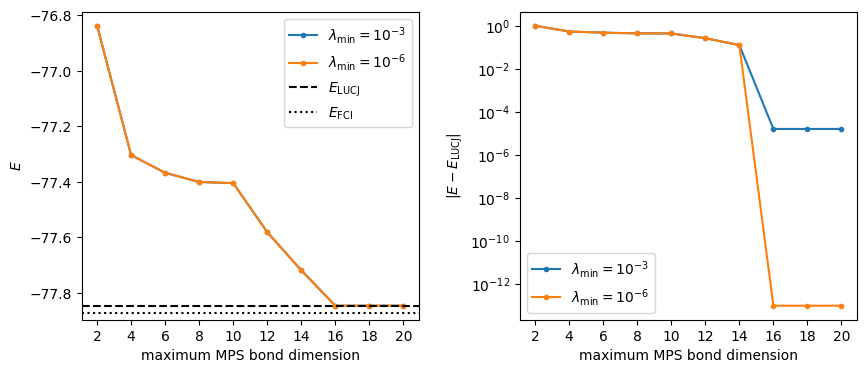

In [6]:
from copy import deepcopy

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

svd_min_list = [1e-3, 1e-6]
chi_max_list = np.arange(2, 21, 2)
lucj_mps_energy = np.zeros((2, len(chi_max_list)))

# Construct Hartree-Fock state
dim = ffsim.dim(norb, nelec)
strings_a, strings_b = ffsim.addresses_to_strings(
    range(dim),
    norb=norb,
    nelec=nelec,
    bitstring_type=ffsim.BitstringType.STRING,
    concatenate=False,
)
initial_mps = bitstring_to_mps(((1 << n_alpha) - 1, (1 << n_beta) - 1), norb)

# Loop over cutoff and bond dimension
for i, svd_min in enumerate(svd_min_list):
    for j, chi_max in enumerate(chi_max_list):
        final_mps = deepcopy(initial_mps)
        options = {"trunc_params": {"chi_max": int(chi_max), "svd_min": svd_min}}
        eng = TEBDEngine(final_mps, None, options)
        apply_ucj_op_spin_balanced(eng, lucj_operator)
        lucj_mps_energy[i, j] = hamiltonian_mpo.expectation_value_finite(final_mps)

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, wspace=0.3)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for i in [0, 1]:
    ax0.plot(
        chi_max_list,
        lucj_mps_energy[i, :],
        ".-",
        label=f"$\\lambda_\\text{{min}}=10^{{{np.log10(svd_min_list[i]):g}}}$",
    )

ax0.set_xlabel("maximum MPS bond dimension")
ax0.set_ylabel("$E$")
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.axhline(y=lucj_energy, color="k", linestyle="dashed", label="$E_\\text{LUCJ}$")
ax0.axhline(y=fci_energy, color="k", linestyle="dotted", label="$E_\\text{FCI}$")
ax0.legend(loc="best")

for i in [0, 1]:
    ax1.plot(
        chi_max_list,
        np.abs(np.subtract(lucj_mps_energy[i, :], lucj_energy)),
        ".-",
        label=f"$\\lambda_\\text{{min}}=10^{{{np.log10(svd_min_list[i]):g}}}$",
    )

ax1.set_xlabel("maximum MPS bond dimension")
ax1.set_ylabel("$|E-E_\\text{LUCJ}|$")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yscale("log")
ax1.legend(loc="best")

plt.show()

From the above plots, we can see that at an MPS bond dimension of 16 or above, the MPS representation of the LUCJ circuit is exact.